In [1]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt

from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
import keras
from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
import warnings

warnings.filterwarnings('ignore')
print("okay")


okay


In [2]:
SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

In [3]:
# Function to generate explanations
# Function explanation for lime

def get_lime_explanation(data, e, L2X=False) :
    # e  = fn = model.predict
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(data.shape[1]*data.shape[2])])

    # Get explanations
    for row in range(data.shape[0]) : 
        explanation = lime_explainer.explain_instance(data[row],
                                                      e,
                                                      num_features=data.shape[1]*data.shape[2]) 
        # fn = model.predict, initialize lime_explainer = Reccurent()
        lime_values = explanation.local_exp[1]
        # Add explanation in df_explanation
        lime_dict = {}
        for tup in lime_values :
            lime_dict[str(tup[0])] = tup[1]
        df_expplanation.loc[len(df_expplanation)] = lime_dict
    
    return df_expplanation

# # Function explanation for others
def get_explainations(data, e, L2X = False) :
    
    # df diemnsion
    if L2X==True :
        X_to_def_col = data[0:1]
        explanation_test = e.explain(X_to_def_col.reshape((X_to_def_col.shape[0], -1)))
        num_columns = explanation_test.flatten().shape[0]
        
    else : 
        explanation_test = e.explain(data[0:1])
        num_columns = explanation_test.flatten().shape[0]
    
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(num_columns)])

    # Get explanations
    for row in range(data.shape[0]) :
        if L2X==True:
            X_row = data[row:row+1]
            explanation = e.explain(X_row.reshape((X_row.shape[0], -1)))
        else :
            explanation = e.explain(data[row:row+1])
        # Add explanation in df_explanation
        explanation = explanation.flatten()
        feature_dict = {}
        for i in range(num_columns) :
            feature_dict[str(i)] = explanation[i]
        df_expplanation.loc[len(df_expplanation)] = feature_dict
    
    return df_expplanation

In [4]:
# Data preparation
# Data loading
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
# train['RUL'].clip(upper=125, inplace=True)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] 

(61249, 27) (41214, 26) (248, 1)


In [5]:
def model004(input_shape,weights_file, nb_layers = None):
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    if nb_layers==1:
        '''
        node = 256, activation = tanh, dropout = 0.3, bs = 64
        '''
        nodes_per_layer = 256
        activation_value= 'tanh'
        dropout = 0.3
        bs = 64

        model = Sequential()
        model.add(LSTM(nodes_per_layer, activation=activation_value, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        
    elif nb_layers == 2 :
        model = Sequential()
        model.add(LSTM(256, activation='tanh', input_shape=input_shape, return_sequences=True))
        model.add(LSTM(64, activation='tanh'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1))
        
    elif nb_layers==3:
        model = Sequential()
        model.add(LSTM(256, activation='tanh', input_shape=input_shape, return_sequences=True))
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        Dropout(0.3)
        # Dense(256, activation = 'relu')
        model.add(LSTM(32, activation='tanh'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1))
    
    elif nb_layers==4:
        model = Sequential()
        model.add(LSTM(256, activation='tanh', input_shape=input_shape, return_sequences=True))
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1))
        
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    model.save_weights(weights_file)

    return model

In [8]:
# models = {
#     'model_1l' : model004,
#     'model_2l' : create_model2C004(),
#     'model_3l' : create_model3C004(),
#     'model_4l' : create_model4C004(),
#     }

In [7]:
# Data preparation
# Data prepration
sequence_length = 35
alpha = 0.2
upper = 125
    
learning_rate_ = 0.001
dropout = 0.4
activation = 'tanh'
epochs = 20
batch_size = 64
train = rul_piecewise_fct(train, upper)

X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
test_array = np.concatenate(list(test_gen)).astype(np.float32)
test_rul = rul_piecewise_fct(y_test,upper)
print(train_array.shape, label_array.shape, test_array.shape)



for md in tqdm.tqdm(range(1,5)):
    #Model creation
    weights_file = "fd004_result/" + str(md) + 'lstm_hyper_parameter_weights.h5'
    input_shape = (sequence_length, len(remaining_sensors))
    model = model004(input_shape=input_shape, weights_file=weights_file, nb_layers=md)

(52783, 35, 14) (52783, 1) (248, 35, 14)


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


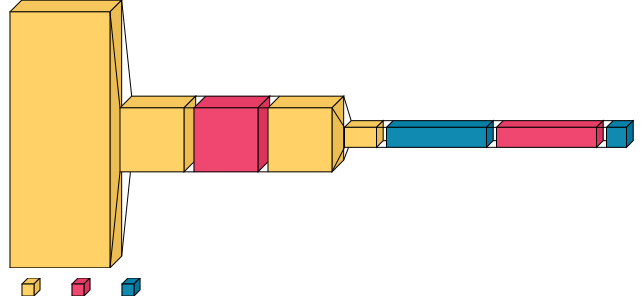

In [25]:
visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=100, legend=True)

In [40]:
# Data preparation
# Data prepration
sequence_length = 35
alpha = 0.2
upper = 125
    
learning_rate_ = 0.001
dropout = 0.4
activation = 'tanh'
epochs = 20
batch_size = 64
train = rul_piecewise_fct(train, upper)

X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
test_array = np.concatenate(list(test_gen)).astype(np.float32)
test_rul = rul_piecewise_fct(y_test,upper)
print(train_array.shape, label_array.shape, test_array.shape)



for md in tqdm.tqdm(range(1,5)):
    #Model creation
    weights_file = "fd004_result/" + str(md) + 'lstm_hyper_parameter_weights.h5'
    input_shape = (sequence_length, len(remaining_sensors))
    model = model004(input_shape=input_shape, weights_file=weights_file, nb_layers=md)
        
    mse_val = []
    R2_val = []
    RMSE = []
    score_val = []
    mse = []
    results = pd.DataFrame()
    # Model fitting
    with tf.device('/device:GPU:0'):
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))

        #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
        #  'nodes':str(nodes_per_layer),
         'dropout':dropout, 'activation':activation, 'batch_size':batch_size,
         'TW' : sequence_length, 'alpha' : alpha, 'upper' : upper}
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)
    results.to_csv('fd004_result/nblayers/performance.csv')
    
    with tf.device('/device:GPU:0'):
            for rd in range(5):

                # Get explanation and calculate the score
                # Echantillonage
                n_individus = test_array.shape[0]

                # # Choisir aléatoirement 5 indices d'individus
                np.random.seed(rd)
                indices_choisis = np.random.choice(n_individus, size=5, replace=False)

                # Sélectionner les données correspondant aux indices choisis
                test_array_sampling = test_array[indices_choisis, :, :]
                label_array_sampling = y_test.values[indices_choisis, :]

                # Afficher les dimensions des données sélectionnées
                print(test_array_sampling.shape, label_array_sampling.shape)
                
                # distance matrix XX'
                X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

                # LIME
                lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                                feature_names=remaining_sensors,
                                                                mode = 'regression',
                                                                )
                lime_values = get_lime_explanation(test_array_sampling, e = model.predict)
                lime_values.shape
                Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

                #Lime's metrics
                list_metrics_lime = {}
                list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
                list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
                list_metrics_lime['stability'] = stability(X_dist, Lime_dist)
                list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model.predict, 
                                                                explainer = get_lime_explanation,
                                                            samples=test_array_sampling,
                                                                targets=label_array, e = model.predict)
                list_metrics_lime['selectivity'] = selectivity(model=model.predict, explainer = get_lime_explanation,
                                                            samples=test_array_sampling, e_x = model.predict)
                list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model.predict)
                list_metrics_lime['Verm_stability'] = stability_Velmurugan(get_lime_explanation, test_array_sampling,
                                                                            e=model.predict, top_features=200)
                list_metrics_lime['fidelity'], list_metrics_lime['sparsity'] = fidelity(model=model.predict, 
                                                                explainer = get_lime_explanation,
                                                                samples=test_array_sampling,
                                                                e = model.predict, L2X=True)
                list_metrics_lime['instability'] = instability(model=model.predict, 
                                                                explainer = get_lime_explanation,
                                                                samples=test_array_sampling,
                                                                e = model.predict, L2X=True)
                
                list_metrics_lime['alpha'] = alpha
                list_metrics_lime['upper'] = upper
                list_metrics_lime['sequence_length'] = sequence_length
                list_metrics_lime['explainer'] = 'lime'
                list_metrics_lime['model'] = md

                df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_lime])])

                # SHAP
                e = KernelSHAP(model)
                shapvalues = get_explainations(test_array_sampling, e)
                shapvalues.shape

                list_metrics_shap = {}
                shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

                list_metrics_shap['identity'] = identity(X_dist, shap_dist)
                list_metrics_shap['separability'] = separability(X_dist, shap_dist)
                list_metrics_shap['stability'] = stability(X_dist, shap_dist)
                list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
                                                                explainer = get_explainations,
                                                            samples=test_array_sampling,
                                                                targets=label_array, e = e)
                list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                                samples=test_array_sampling, e_x=e)
                list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)
                list_metrics_shap['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
                                                                            e=e, top_features=200)
                list_metrics_shap['fidelity'], list_metrics_shap['sparsity']= fidelity(model=model.predict, 
                                                                explainer = get_explainations,
                                                                samples=test_array_sampling,
                                                                e = e)
                list_metrics_shap['instability']= instability(model=model.predict, 
                                                                explainer = get_explainations,
                                                                samples=test_array_sampling,
                                                                e = e)
                
                list_metrics_shap['alpha'] = alpha
                list_metrics_shap['upper'] = upper
                list_metrics_shap['sequence_length'] = sequence_length
                list_metrics_shap['explainer'] = 'shap'
                list_metrics_shap['model'] = md

                df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
                
                # L2X
                e = L2X(model.predict, test_array_sampling)
                l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
                l2xvalues.shape

                # L2X's metrics
                list_metrics_l2x = {}
                l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

                list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
                list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
                list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)
                list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model.predict, explainer = get_explainations,
                                                            samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)
                list_metrics_l2x['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                                samples=test_array_sampling, e_x=e, L2X=True)
                list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)
                list_metrics_l2x['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
                                                                            e=e, top_features=200, L2X=True)
                list_metrics_l2x['fidelity'], list_metrics_l2x['sparsity']= fidelity(model=model.predict, 
                                                                explainer = get_explainations,
                                                                samples=test_array_sampling,
                                                                e = e, L2X=True)
                list_metrics_l2x['instability'] = instability(model=model.predict, 
                                                                explainer = get_explainations,
                                                                samples=test_array_sampling,
                                                                e = e, L2X=True)
                
                list_metrics_l2x['alpha'] = alpha
                list_metrics_l2x['upper'] = upper
                list_metrics_l2x['sequence_length'] = sequence_length
                list_metrics_l2x['explainer'] = 'l2x'
                list_metrics_l2x['model'] = md


                df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_l2x])])
            df_metrics.to_csv('fd004_result/nblayers/quality_by_layer.csv')

(52783, 35, 14) (52783, 1) (248, 35, 14)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20
825/825 [==============================] - 40s 43ms/step - loss: 2299.0552 - val_loss: 2032.4381
Epoch 2/20
825/825 [==============================] - 38s 47ms/step - loss: 1772.2677 - val_loss: 2074.6436
Epoch 3/20
825/825 [==============================] - 38s 46ms/step - loss: 1772.8175 - val_loss: 2082.2363
Epoch 4/20
825/825 [==============================] - 37s 45ms/step - loss: 1770.1199 - val_loss: 2098.2375
Epoch 5/20
825/825 [==============================] - 39s 47ms/step - loss: 1454.6582 - val_loss: 688.9807
Epoch 6/20
825/825 [==============================] - 40s 48ms/step - loss: 401.9694 - val_loss: 337.3282
Epoch 7/20
478/825 [================>.............] - ETA: 16s - loss: 319.7933

  0%|          | 0/1 [04:14<?, ?it/s]


KeyboardInterrupt: 

In [18]:
for kk in range(1,5):
    print(kk)

1
2
3
4


In [12]:
df_metrics

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen,Verm_stability,fidelity,sparsity,instability,alpha,upper,sequence_length,explainer,model
0,1.0,1.0,1.0,0.396575,0.859858,0.231712,0.600059,0.010349,0.745336,0.038609,0.018315,0.496626,0.2,125,39,lime,model_1l
0,1.0,1.0,1.0,0.079117,1.384176,0.152816,0.602597,0.484440,1.000000,0.691115,0.018315,0.525450,0.2,125,39,shap,model_1l
0,1.0,1.0,1.0,0.317976,4.816301,0.157744,0.620165,0.019596,1.000000,0.026011,0.018315,0.656410,0.2,125,39,l2x,model_1l
0,1.0,1.0,1.0,0.232725,2.564634,0.215667,0.663364,0.079706,0.604761,0.084158,0.018315,0.331964,0.2,125,39,lime,model_1l
0,1.0,1.0,1.0,0.004815,0.676175,0.005961,0.653576,0.490018,1.000000,0.719074,0.000000,0.501500,0.2,125,39,shap,model_1l
0,1.0,1.0,1.0,0.185049,17.869755,0.162726,0.628326,0.041394,1.000000,0.207279,0.018315,0.560001,0.2,125,39,l2x,model_1l
0,1.0,1.0,1.0,0.170843,0.572378,0.199016,0.679362,0.057615,0.564015,0.103174,0.018315,0.399297,0.2,125,39,lime,model_1l
0,1.0,1.0,1.0,0.128458,0.720116,0.208400,0.657258,0.450789,1.000000,0.405441,0.007326,0.338765,0.2,125,39,shap,model_1l
0,1.0,1.0,1.0,0.202384,29.547411,0.226149,0.637773,0.043963,1.000000,0.265515,0.018315,0.466667,0.2,125,39,l2x,model_1l
0,1.0,1.0,1.0,0.381330,0.115990,0.286515,0.590704,0.178128,0.596612,0.060922,0.018315,0.349753,0.2,125,39,lime,model_1l
